This notebook shows a few cases of how to use viiflow together with the plot functions in the matplotlib library and the viiflowtools package to visualize the results.

In [1]:
%matplotlib inline
import os
#os.environ["OMP_NUM_THREADS"] = "1"
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

# Solve an airfoil for a single AOA
N = 180
AF = vft.repanel(vft.read_selig("S1210.dat"),N,LEFAC=3)

# Calculation of a single AOA
s = vf.setup(Re=5e5,Ma=0,Ncrit=8,Alpha=10,WakeLength = 1.5)


# Run for that AOA
[p,bl,x] = vf.init(AF,s)
[x,flag,res,grad,_] = vf.iter(x,bl,p,s)

Iteration 11, |res| 0.000043, lam 1.000000


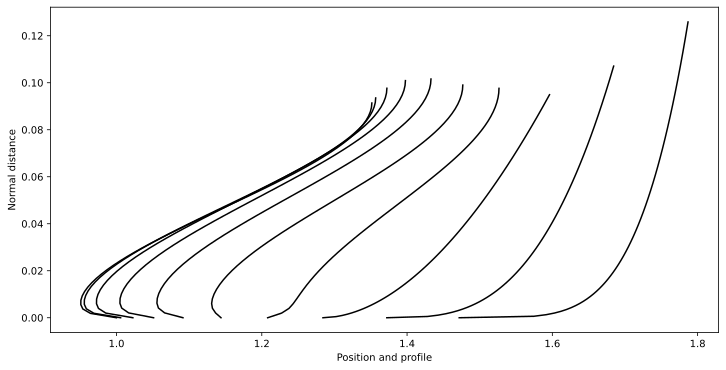

In [2]:
# Some plotting defaults
ratio = [12,6]
matplotlib.rcParams['figure.figsize'] = ratio
# Plot local boundary layer profile

# Buffers
Y = np.zeros((50))
U = np.zeros((50))

# Plot profile development in wake
fig,ax = plt.subplots(1,1)
for k in range(0,20,2):
    vf.viscid_profile(bl[0].bl_wk.nodes[k],Y,U)
    ax.plot(p.wakes[0].X[0,k]+U/3,Y,'-k')
ax.set_xlabel('Position and profile')
ax.set_ylabel('Normal distance');

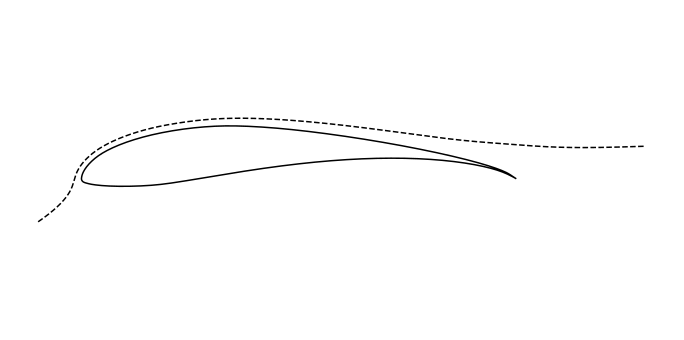

In [3]:
# Integrate a single streamline using the inviscid model 
N = 1500 # Num. of treamline elements
x = np.zeros((2,N))
x[0,0] = -0.1
x[1,0] = -0.1
v = np.zeros((2,1)) # Velocity buffer
for k in range(1,N):
    vf.inviscid_velocity(p,x[:,k-1:k],v[:,0:1])
    # Normalize for streamline integration
    v/=np.sqrt(v[0]**2+v[1]**2)
    # Tiny step forward
    x[:,k] = x[:,k-1] + v[:,0]*1e-3

# Plot with airfoil
fig,ax = plt.subplots(1,1)
ax.plot(x[0,:],x[1,:],'--k')
ax.plot(p.foils[0].X[0,:],p.foils[0].X[1,:],'-k')
ax.axis('equal');
ax.axis('off');

0.27699828147888184


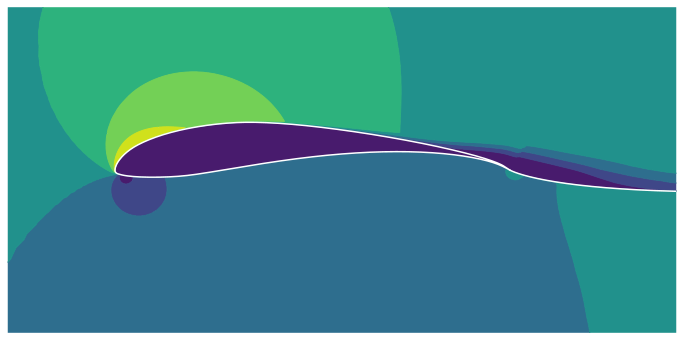

In [4]:
# Complete flow field
# Because evaluating the grid of points with the panel solution is rather expensive, this can take a moment
# The plot is done using a rather low amount of contours, because this is saved as a svg inside this notebook 
# and put on the internet. 
import time
Nbl = 30 # Num. of normal elements in boundary layer
Nin = 500 # Num. of normal inviscid elements beyond the boundary layer
hy = 0.6 # Distance from the airfoil and wake up to which the field is calculated
tic = time.time()
[x,y,UI,VI] = vfp.total_flowfield(p,bl,Nbl,Nin,hy)
toc = time.time()
print(toc-tic)
fig,ax = plt.subplots(1,1)
CS=ax.tricontourf(x.ravel(),y.ravel(),np.sqrt((UI**2+VI**2)).ravel(),6)
ax.axis('equal')
ax.plot(p.foils[0].X[0,:],p.foils[0].X[1,:],'-w')
ax.plot(p.wakes[0].X[0,:],p.wakes[0].X[1,:],'-w')

xlims = (-.25,1.4)
ylims = (-(xlims[1]-xlims[0])*ratio[1]/ratio[0]/2,(xlims[1]-xlims[0])*ratio[1]/ratio[0]/2)
ax.set(xlim=xlims,ylim=ylims);


# This is a modification so that nice svgs are plotted
# See https://github.com/matplotlib/matplotlib/issues/4419
for a in CS.collections:
    a.set_edgecolor('face')
ax.axis('off');

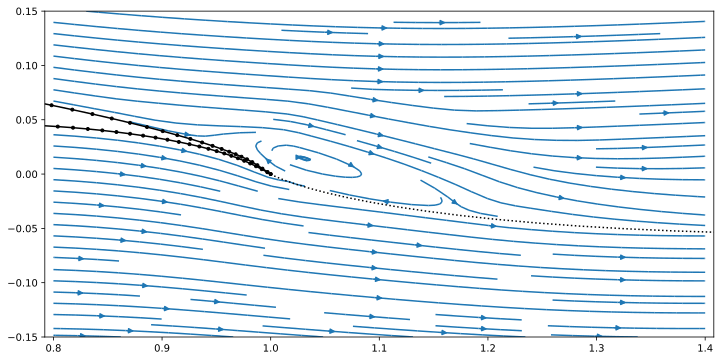

In [5]:
# Plot streamlines

# Make interpolating function for evaluation at arbitrary points
import scipy
intpU = scipy.interpolate.LinearNDInterpolator(np.c_[x.ravel(),y.ravel()], UI.ravel(), fill_value=np.nan, rescale=False)
intpV = scipy.interpolate.LinearNDInterpolator(np.c_[x.ravel(),y.ravel()], VI.ravel(), fill_value=np.nan, rescale=False)

# Meshgrid for streamplot
zoomx = [.8,1.4]
rat = ratio[1]/ratio[0]/2*(zoomx[1]-zoomx[0])
zoomy = [-rat,rat]
Nzoom = 200
Y,X = np.mgrid[zoomy[0]:zoomy[1]:complex(Nzoom),zoomx[0]:zoomx[1]:complex(Nzoom)]
U = intpU(X,Y)
V = intpV(X,Y)


fig,ax = plt.subplots(1,1)
ax.streamplot(X, Y, U, V)
ax.plot(p.foils[0].X[0,:],p.foils[0].X[1,:],'.-k')
ax.plot(p.wakes[0].X[0,:],p.wakes[0].X[1,:],':k')
ax.axis('equal');
ax.set(xlim=zoomx,ylim=zoomy);

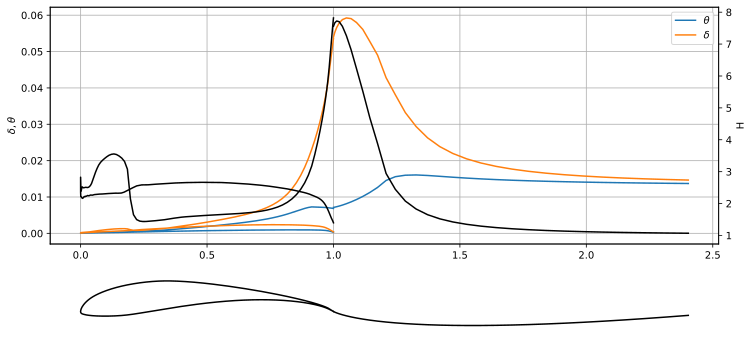

In [6]:
# Closer look at some boundary layer quantities
cmap = plt.get_cmap("tab10")
fig,ax = plt.subplots(2,1,gridspec_kw={'height_ratios': [4, 1]})
X = p.foils[0].X[0,:]
Xw = p.wakes[0].X[0,:]
ax[0].plot(X,bl[0].bl_fl.nodes.theta,color="tab:blue",label=r"$\theta$")
ax[0].plot(Xw,bl[0].bl_wk.nodes.theta,color="tab:blue")
ax[0].plot(X,bl[0].bl_fl.nodes.delta,color="tab:orange",label=r"$\delta$")
ax[0].plot(Xw,bl[0].bl_wk.nodes.delta,color="tab:orange")
axH = ax[0].twinx()  # instantiate a second axes that shares the same x-axis
axH.plot(X,bl[0].bl_fl.nodes.H,color="k",label="H")
axH.plot(Xw,bl[0].bl_wk.nodes.H,color="k")
ax[0].legend(frameon=True)
axH.set_ylabel('H')
ax[0].grid(1)
ax[0].set_ylabel(r"$\delta,\theta$")

ax[1].plot(p.foils[0].X[0,:],p.foils[0].X[1,:],'-k')
ax[1].plot(p.wakes[0].X[0,:],p.wakes[0].X[1,:],'-k')
ax[1].axis('equal');
ax[1].axis('off');